In [ ]:
import mlflow
from pyspark.sql import SparkSession
import mlflow.spark

# Start Spark session
spark = SparkSession.builder.appName("ErrorAnalysis").getOrCreate()

# Load model from MLflow run
mlflow.set_tracking_uri("file:///h:/Desktop/00- Projects/hiv_classification/mlruns")
model_uri = "runs:/d2260fb0b1154aeba537ef3f72dda977/random_forest_model"  
model = mlflow.spark.load_model(model_uri)

# Load dataset
df = spark.read.parquet("../data/processed/hiv_prepared.parquet")

# Split 
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

2025/08/11 10:34:31 INFO mlflow.spark: URI 'runs:/d2260fb0b1154aeba537ef3f72dda977/random_forest_model/sparkml' does not point to the current DFS.
2025/08/11 10:34:31 INFO mlflow.spark: File 'runs:/d2260fb0b1154aeba537ef3f72dda977/random_forest_model/sparkml' not found on DFS. Will attempt to upload the file.
2025/08/11 10:34:32 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/5a91745f-f0ad-4984-8636-f46cc20d5820


In [5]:
predictions = model.transform(test_df)
predictions.select("label", "prediction", "probability").show(5, truncate=False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.777098614175068,0.222901385824932]   |
|1    |1.0       |[0.4985418123081579,0.501458187691842]  |
|0    |0.0       |[0.6829613516661571,0.3170386483338428] |
|1    |0.0       |[0.7719266598992804,0.22807334010071956]|
|0    |0.0       |[0.8410509858859775,0.15894901411402249]|
+-----+----------+----------------------------------------+
only showing top 5 rows


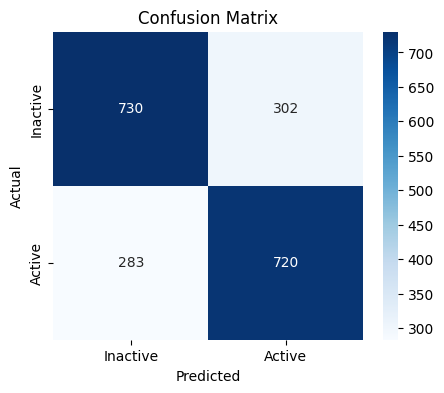

              precision    recall  f1-score   support

    Inactive       0.72      0.71      0.71      1032
      Active       0.70      0.72      0.71      1003

    accuracy                           0.71      2035
   macro avg       0.71      0.71      0.71      2035
weighted avg       0.71      0.71      0.71      2035



In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame into Pandas
preds_pd = predictions.select("label", "prediction").toPandas()

# Confusion matrix
cm = confusion_matrix(preds_pd["label"], preds_pd["prediction"])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Inactive", "Active"],
            yticklabels=["Inactive", "Active"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(preds_pd["label"], preds_pd["prediction"], target_names=["Inactive", "Active"]))


In [7]:

preds_pd = predictions.select("label", "prediction", "probability").toPandas()


false_positives = preds_pd[(preds_pd["label"] == 0) & (preds_pd["prediction"] == 1)]
print(f" False positives: {false_positives.shape[0]}")
display(false_positives.sample(min(5, len(false_positives))))


false_negatives = preds_pd[(preds_pd["label"] == 1) & (preds_pd["prediction"] == 0)]
print(f" False negatives: {false_negatives.shape[0]}")
display(false_negatives.sample(min(5, len(false_negatives))))


 False positives: 302


,label,prediction,probability
1665,0,1.0,"[0.2885120137684474, 0.7114879862315525]"
360,0,1.0,"[0.3726987681094631, 0.6273012318905369]"
1204,0,1.0,"[0.32275189049737824, 0.6772481095026218]"
687,0,1.0,"[0.3877028575351958, 0.6122971424648042]"
640,0,1.0,"[0.2792309783310758, 0.7207690216689242]"


 False negatives: 283


,label,prediction,probability
719,1,0.0,"[0.578869466147535, 0.4211305338524651]"
374,1,0.0,"[0.5119283925276339, 0.48807160747236605]"
717,1,0.0,"[0.7671548852107613, 0.2328451147892387]"
2003,1,0.0,"[0.6104950580777129, 0.38950494192228713]"
469,1,0.0,"[0.5586173551511294, 0.4413826448488706]"


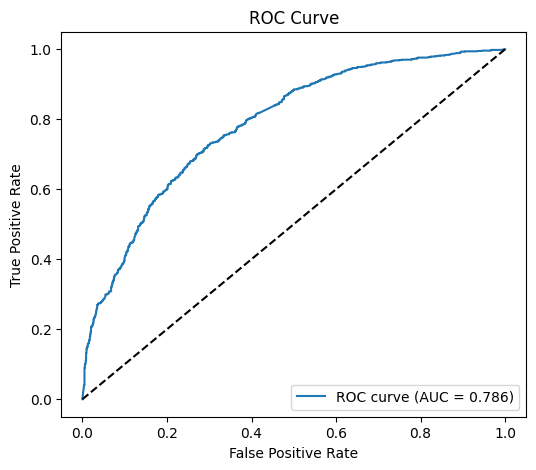

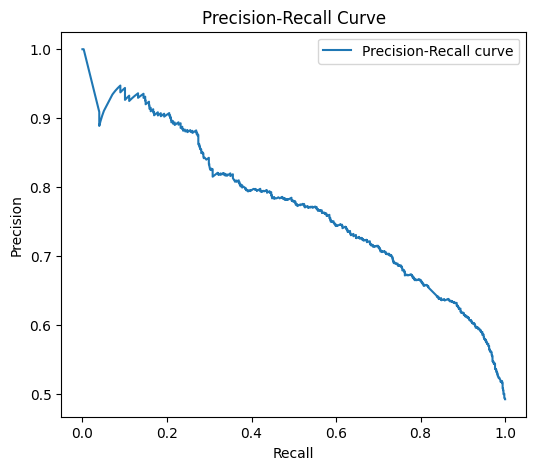

In [9]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

probs = preds_pd["probability"].apply(lambda x: x[1])
labels = preds_pd["label"]

# --- Courbe ROC ---
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--") 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# --- Courbe Precision-Recall ---
precision, recall, _ = precision_recall_curve(labels, probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()


In [10]:
from sklearn.metrics import f1_score

best_threshold = 0.5
best_f1 = 0

for t in [i/100 for i in range(1, 100)]:
    preds_t = (probs >= t).astype(int)
    f1 = f1_score(labels, preds_t)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f" Best threshold for F1-score: {best_threshold:.2f} (F1 = {best_f1:.4f})")


 Best threshold for F1-score: 0.38 (F1 = 0.7371)


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_metrics(threshold):
    preds_t = (probs >= threshold).astype(int)
    acc = accuracy_score(labels, preds_t)
    prec = precision_score(labels, preds_t)
    rec = recall_score(labels, preds_t)
    f1 = f1_score(labels, preds_t)
    return acc, prec, rec, f1

# Comparaison
metrics_default = get_metrics(0.5)
metrics_best = get_metrics(0.38)

import pandas as pd
df_compare = pd.DataFrame(
    [metrics_default, metrics_best],
    index=["Threshold 0.50", "Threshold 0.38"],
    columns=["Accuracy", "Precision", "Recall", "F1-score"]
)

print(df_compare)


                Accuracy  Precision    Recall  F1-score
Threshold 0.50  0.712531   0.704501  0.717846  0.711111
Threshold 0.38  0.689435   0.632405  0.883350  0.737105


We selected a decision threshold of 0.38 instead of the default 0.50 because it significantly increases recall (from 0.72 to 0.88) while also improving the F1-score, ensuring that more active compounds are correctly identified at the expense of a moderate drop in precision.